<a href="https://colab.research.google.com/github/kingjuno/AdventOfCode2021/blob/master/pretrained_network_with_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use a pre-trained network with transfer learning

Training CNN's can take a lot of time, and a lot of data is required for that task. However, much of the time is spent to learn the best low-level filters that a network is using to extract patterns from images.
The approach of using a neural network trained on one dataset and adapt it to classifying different images without fulltraining is called **transfer learning**. In transfer learning, we typically start with a pre-trained model, which has been trained on some large image dataset, such as ImageNet. Those models can already do a good job extracting different features from generic images, and in many cases just building a classifier on top of those extracted features can yield a good result.

In [2]:
!pip install torchinfo
!git clone https://github.com/kingjuno/computer-vision
!mv computer-vision/intro/utils.py .

Cloning into 'computer-vision'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 42 (delta 10), reused 38 (delta 6), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [3]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import os

from utils import *

# Cats vs Dogs Datasets


In [4]:
if not os.path.exists('data/kagglecatsanddogs_3367a.zip'):
    !wget -P data -q https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
import zipfile
if not os.path.exists('data/PetImages'):
    with zipfile.ZipFile('data/kagglecatsanddogs_3367a.zip', 'r') as zip_ref:
        zip_ref.extractall('data')
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

Corrupt image: data/PetImages/Cat/666.jpg


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

Corrupt image: data/PetImages/Dog/11702.jpg


Next, let's load the images into PyTorch dataset, converting them to tensors and doing some normalization. We will apply std_normalize transform to bring images to the range expected by pre-trained VGG network:

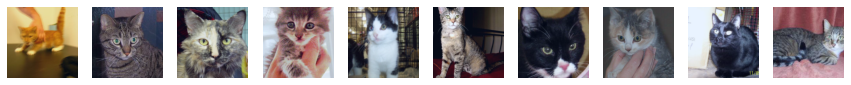

In [5]:
std_normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    std_normalize
])

dataset = torchvision.datasets.ImageFolder('data/PetImages', transform=trans)
trainset, testset = torch.utils.data.random_split(dataset, [20000, len(dataset) - 20000])

display_dataset(dataset)

# Pre-trained models
There are many different pre-trained models available inside `torchvision` module, and even more models can be found on the internet.

In [6]:
vgg = torchvision.models.vgg16(pretrained = True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

tensor(263)


In [7]:
import json, requests
class_map = json.loads(requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json").text)
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

['n02113023', 'Pembroke']

Let's also see the architecture of the VGG-16 network:

In [8]:
summary(vgg, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In addition to the layer we already know, there is also another layer type called Dropout. These layers act as regularization technique. Regularization makes slight modifications to the learning algorithm so the model generalizes better. During training, dropout layers discard some proportion (around 30%) of the neurons in the previous layer, and training happens without them. This helps to get the optimization process out of local minima, and to distribute decisive power between different neural paths, which improves overall stability of the network.

# GPU Computation
Deep neural networks, such as VGG-16 and other more modern architectures require quite a lot of computational power to run. It makes sense to use GPU acceleration, if it is available. In order to do so, we need to explicitly move all tensors involved in the computation to GPU.

The way it is normally done is to check the availability of GPU in the code, and define device variable that points to the computational device - either GPU or CPU.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on device = {}'.format(device))

vgg.to(device)
sample_image = sample_image.to(device)

vgg(sample_image).argmax()

Doing computations on device = cpu


tensor(281)

# Exctracting VGG features
If we want to use VGG-16 to extract features from our images, we need the model without final classification layers. In fact, this "feature extractor" can be obtained using vgg.features method:

torch.Size([1, 512, 7, 7])


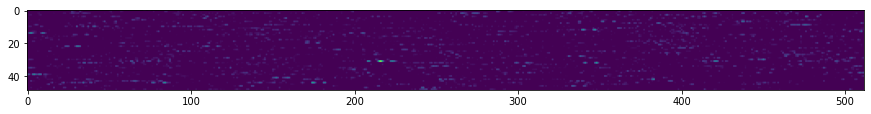

In [10]:
res = vgg.features(sample_image).cpu()
plt.figure(figsize=(15,3))
plt.imshow(res.detach().view(-1,512))
print(res.size())

The dimension of feature tensor is 512x7x7, but in order to visualize it we had to reshape it to 2D form.

Now let's try to see if those features can be used to classify images. Let's manually take some portion of images (800 in our case), and pre-compute their feature vectors. We will store the result in one big tensor called feature_tensor, and also labels into label_tensor:

In [11]:
bs = 8
dl = torch.utils.data.DataLoader(dataset,batch_size=bs,shuffle=True)
num = bs*100
feature_tensor = torch.zeros(num,512*7*7).to(device)
label_tensor = torch.zeros(num).to(device)
i = 0
for x,l in dl:
    with torch.no_grad():
        f = vgg.features(x.to(device))
        feature_tensor[i:i+bs] = f.view(bs,-1)
        label_tensor[i:i+bs] = l
        i+=bs
        print('.',end='')
        if i>=num:
            break


....................................................................................................

Now we can define vgg_dataset that takes data from this tensor, split it into training and test sets using random_split function, and train a small one-layer dense classifier network on top of extracted features:

In [12]:
vgg_dataset = torch.utils.data.TensorDataset(feature_tensor,label_tensor.to(torch.long))
train_ds, test_ds = torch.utils.data.random_split(vgg_dataset,[700,100])

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=32)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=32)

net = torch.nn.Sequential(torch.nn.Linear(512*7*7,2),torch.nn.LogSoftmax()).to(device)

history = train(net,train_loader,test_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch  0, Train acc=0.876, Val acc=0.980, Train loss=0.124, Val loss=0.067
Epoch  1, Train acc=0.987, Val acc=0.970, Train loss=0.008, Val loss=0.094
Epoch  2, Train acc=0.996, Val acc=0.960, Train loss=0.005, Val loss=0.113
Epoch  3, Train acc=0.997, Val acc=0.960, Train loss=0.001, Val loss=0.109
Epoch  4, Train acc=0.999, Val acc=0.980, Train loss=0.001, Val loss=0.066
Epoch  5, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.102
Epoch  6, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.107
Epoch  7, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.108
Epoch  8, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.108
Epoch  9, Train acc=1.000, Val acc=0.960, Train loss=0.000, Val loss=0.108
